In [3]:
import os
import cv2
import numpy as np
import pywt
import joblib
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestRegressor  # For regression
from sklearn.metrics import mean_squared_error  # For regression performance evaluation
from sklearn.ensemble import RandomForestRegressor  # For regression
from sklearn.metrics import mean_squared_error  # For regression performance evaluation
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [4]:
def load_xray_images_in_chunks(data_dir, target_size=(128, 128), chunk_size=100):
    images = []
    labels = []
    
    # Assuming three folders: 'Covid', 'Viral Pneumonia', and 'Normal'
    print(f"Loading data from {data_dir}...")
    
    for label_dir in os.listdir(data_dir):
        label_path = os.path.join(data_dir, label_dir)
        if os.path.isdir(label_path):
            print(f"Found directory: {label_dir}")
            
            if label_dir == 'othercovid':
                label = 0  # Assign 0 for Covid
            #elif label_dir == 'vpnoaug':
                #label = 1  # Assign 1 for Viral Pneumonia
            elif label_dir == 'normal':
                label = 2  # Assign 2 for Normal
            else:
                continue  # Skip any other folders that don't match the expected names
            
            # Load images in chunks
            chunk_images = []
            chunk_labels = []
            
            for idx, file_name in enumerate(os.listdir(label_path)):
                if idx >= chunk_size:  # If we reach the chunk size, yield and reset
                    if chunk_images:  # Ensure chunk is not empty
                        yield np.array(chunk_images), np.array(chunk_labels)
                    chunk_images = []
                    chunk_labels = []
                
                file_path = os.path.join(label_path, file_name)
                try:
                    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)  # Load image in grayscale
                    if img is None:
                        print(f"Error reading image {file_path}")
                        continue
                    
                    img = cv2.resize(img, target_size)  # Resize to target size
                    chunk_images.append(img)
                    chunk_labels.append(label)  # Append the label for the image
                except Exception as e:
                    print(f"Error loading image {file_path}: {e}")
            
            # Yield the last chunk if there are remaining images
            if chunk_images:
                yield np.array(chunk_images), np.array(chunk_labels)

In [6]:
def wavelet_transform(images, wavelet='db4', level=3, dtype=np.float32):
    features = []
    for img in images:
        # Perform 2D wavelet decomposition
        coeffs = pywt.wavedec2(img, wavelet=wavelet, level=level)
        
        # Flatten all coefficients properly (handle nested tuples)
        coeffs_flat = np.concatenate([ 
            c.flatten() if isinstance(c, np.ndarray) else np.concatenate([x.flatten() for x in c]) for c in coeffs
        ])
        
        # Convert the features to a smaller data type (float32) to save memory
        features.append(coeffs_flat.astype(dtype))
    
    return np.array(features)

In [7]:
def train_on_chunked_data_with_cross_validation(data_dir, chunk_size=100):
    X_train_list = []
    y_train_list = []

    # Load and process data in chunks
    for chun
            continuek_images, chunk_labels in load_xray_images_in_chunks(data_dir, chunk_size=chunk_size):
        if chunk_images.size == 0:  # Ensure chunk is not empty
        
        # Process each chunk
        wavelet_features = wavelet_transform(chunk_images, level=3)  #
        
        #Use a smaller wavelet level for memory efficiency
        X_train_list.append(wavelet_features)
        y_train_list.append(chunk_labels)
    
    # Check if we have valid data to concatenate
    if X_train_list and y_train_list:
        # Combine all chunks into one dataset for training
        X_train = np.concatenate(X_train_list, axis=0)
        y_train = np.concatenate(y_train_list, axis=0)

        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=42)
        
        # Cross-validation using RandomForestClassifier
        clf = RandomForestClassifier(n_estimators=100, random_state=42) #####################
        
        # Perform cross-validation with 5 splits
        cross_val_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
        
        # Output the cross-validation results
        print(f"Cross-validation scores: {cross_val_scores}")
        print(f"Mean accuracy: {cross_val_scores.mean():.2f} (+/- {cross_val_scores.std() * 2:.2f})")
        
        # Train the model on the entire training dataset
        clf.fit(X_train, y_train)
        
        # Evaluate the model on the test set (not training set)
        y_pred_test = clf.predict(X_test)
        
        # Test Accuracy and Evaluation metrics
        print(f"Test Accuracy: {accuracy_score(y_test, y_pred_test):.2f}")
        print("Confusion Matrix (Test):")
        print(confusion_matrix(y_test, y_pred_test, labels=[0, 2]))  # Specifying the labels for multi-class
        print("Classification Report (Test):")
        print("Classification Report (Test):")
        print(classification_report(y_test, y_pred_test, target_names=["Covid", "Normal"], labels=[0, 2]))
        return clf
    else:
        print("No valid data to train the model.")
        return None


In [8]:
data_dir = r"F:\GRAD PROJECT\Dataset"
model = train_on_chunked_data_with_cross_validation(data_dir, chunk_size=100)
joblib.dump(model, 'C:/Users/Rashad/Documents/gradproj.pkl')

Loading data from F:\GRAD PROJECT\Dataset...
Found directory: COVID MIXED
Found directory: normal
Error reading image F:\GRAD PROJECT\Dataset\normal\._IM-0115-0001.jpeg
Error reading image F:\GRAD PROJECT\Dataset\normal\._IM-0117-0001.jpeg
Error reading image F:\GRAD PROJECT\Dataset\normal\._IM-0119-0001.jpeg
Error reading image F:\GRAD PROJECT\Dataset\normal\._IM-0122-0001.jpeg
Error reading image F:\GRAD PROJECT\Dataset\normal\._IM-0125-0001.jpeg
Error reading image F:\GRAD PROJECT\Dataset\normal\._IM-0127-0001.jpeg
Error reading image F:\GRAD PROJECT\Dataset\normal\._IM-0128-0001.jpeg
Error reading image F:\GRAD PROJECT\Dataset\normal\._IM-0129-0001.jpeg
Error reading image F:\GRAD PROJECT\Dataset\normal\._IM-0131-0001.jpeg
Error reading image F:\GRAD PROJECT\Dataset\normal\._IM-0133-0001.jpeg
Error reading image F:\GRAD PROJECT\Dataset\normal\._IM-0135-0001.jpeg
Error reading image F:\GRAD PROJECT\Dataset\normal\._IM-0137-0001.jpeg
Error reading image F:\GRAD PROJECT\Dataset\normal

['C:/Users/Rashad/Documents/gradproj.pkl']

In [6]:
def predict_new_image(model, image_path, target_size=(128, 128)):
    # Load and preprocess the image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Error reading image {image_path}")
        return
    
    img = cv2.resize(img, target_size)  # Resize to match training data
    img_wavelet_features = wavelet_transform([img], level=3)  # Apply wavelet transform
    
    # Use the trained model to make a prediction
    prediction = model.predict(img_wavelet_features)
    class_names = ["Covid", "Viral Pneumonia", "Normal"]
    predicted_class = class_names[prediction[0]]  # Convert numerical label to class name
    
    print(f"Predicted class for the input image: {predicted_class}")

In [7]:
if model:
    new_image_path = r"F:\GRAD PROJECT\1-s2.0-S0720048X04000907-gr4.jpg"
    predict_new_image(model, new_image_path)
else:
    print("Model is not loaded.")

Predicted class for the input image: Covid


In [8]:
def predict_dataset(model, data_dir, target_size=(128, 128), wavelet_level=3):
   
    predictions = {}

 
    for file_name in os.listdir(data_dir):
        file_path = os.path.join(data_dir, file_name)
        
        
        try:
     
            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                print(f"Error reading image {file_path}")
                continue
            
            # Resize the image
            img = cv2.resize(img, target_size)
            

            img_wavelet_features = wavelet_transform([img], level=wavelet_level)
            

            prediction = model.predict(img_wavelet_features)
            

            class_names = ["Covid", "Viral Pneumonia", "Normal"]
            predicted_class = class_names[prediction[0]]  
            
            predictions[file_name] = predicted_class  
            
        except Exception as e:
            print(f"Error processing image {file_path}: {e}")

    return predictions

In [9]:
##100% covid
data_dir = r"F:\GRAD PROJECT\232323\images"  # Directory containing images to predict
predicted_classes = predict_dataset(model, data_dir, target_size=(128, 128), wavelet_level=3)

# Dictionary to store counts of each predicted class
class_counts = {}

# Total number of predictions
total_predictions = len(predicted_classes)

# Print predictions for each image
for image_name, predicted_class in predicted_classes.items():
    print(f"Image: {image_name}, Predicted Class: {predicted_class}")
    
    # Count occurrences of each class
    if predicted_class not in class_counts:
        class_counts[predicted_class] = 0
    class_counts[predicted_class] += 1

# Print the ratio of each class
print("\nClass Ratios:")
for class_name, count in class_counts.items():
    ratio = count / total_predictions
    print(f"Class: {class_name}, Count: {count}, Ratio: {ratio:.2f}")

Image: 01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg, Predicted Class: Covid
Image: 03BF7561-A9BA-4C3C-B8A0-D3E585F73F3C.jpeg, Predicted Class: Covid
Image: 1-s2.0-S0140673620303706-fx1_lrg.jpg, Predicted Class: Covid
Image: 1-s2.0-S0929664620300449-gr2_lrg-a.jpg, Predicted Class: Covid
Image: 1-s2.0-S0929664620300449-gr2_lrg-b.jpg, Predicted Class: Covid
Image: 1-s2.0-S0929664620300449-gr2_lrg-c.jpg, Predicted Class: Covid
Image: 1-s2.0-S0929664620300449-gr2_lrg-d.jpg, Predicted Class: Covid
Image: 1-s2.0-S1684118220300608-main.pdf-001.jpg, Predicted Class: Covid
Image: 1-s2.0-S1684118220300608-main.pdf-002.jpg, Predicted Class: Covid
Image: 1-s2.0-S1684118220300682-main.pdf-002-a1.png, Predicted Class: Covid
Image: 1-s2.0-S1684118220300682-main.pdf-002-a2.png, Predicted Class: Covid
Image: 1-s2.0-S1684118220300682-main.pdf-003-b1.png, Predicted Class: Normal
Image: 1-s2.0-S1684118220300682-main.pdf-003-b2.png, Predicted Class: Covid
Image: 1.CXRCTThoraximagesofCOVID-19fromSingapore.pdf-0

In [10]:
#100% normal
data_dir = r"F:\GRAD PROJECT\viralp\Covid19-dataset\train\Normal"  # Directory containing images to predict
predicted_classes = predict_dataset(model, data_dir, target_size=(128, 128), wavelet_level=3)

# Dictionary to store counts of each predicted class
class_counts = {}

# Total number of predictions
total_predictions = len(predicted_classes)

# Print predictions for each image
for image_name, predicted_class in predicted_classes.items():
    print(f"Image: {image_name}, Predicted Class: {predicted_class}")
    
    # Count occurrences of each class
    if predicted_class not in class_counts:
        class_counts[predicted_class] = 0
    class_counts[predicted_class] += 1

# Print the ratio of each class
print("\nClass Ratios:")
for class_name, count in class_counts.items():
    ratio = count / total_predictions
    print(f"Class: {class_name}, Count: {count}, Ratio: {ratio:.2f}")

Image: 01.jpeg, Predicted Class: Normal
Image: 010.jpeg, Predicted Class: Normal
Image: 011.jpeg, Predicted Class: Normal
Image: 012.jpeg, Predicted Class: Covid
Image: 013.jpeg, Predicted Class: Normal
Image: 014.jpeg, Predicted Class: Normal
Image: 015.jpeg, Predicted Class: Normal
Image: 016.jpeg, Predicted Class: Covid
Image: 017.jpeg, Predicted Class: Normal
Image: 018.jpeg, Predicted Class: Normal
Image: 019.jpeg, Predicted Class: Normal
Image: 02.jpeg, Predicted Class: Covid
Image: 020.jpeg, Predicted Class: Normal
Image: 021.jpeg, Predicted Class: Normal
Image: 022.jpeg, Predicted Class: Normal
Image: 023.jpeg, Predicted Class: Normal
Image: 024.jpeg, Predicted Class: Normal
Image: 025.jpeg, Predicted Class: Normal
Image: 03.jpeg, Predicted Class: Normal
Image: 04.jpeg, Predicted Class: Normal
Image: 05.jpeg, Predicted Class: Covid
Image: 050.jpeg, Predicted Class: Covid
Image: 051.jpeg, Predicted Class: Normal
Image: 052.jpeg, Predicted Class: Normal
Image: 053.jpeg, Predicted

In [11]:

data_dir = r"F:\GRAD PROJECT\viralp\Covid19-dataset\train\Viral Pneumonia"  # Directory containing images to predict
predicted_classes = predict_dataset(model, data_dir, target_size=(128, 128), wavelet_level=3)

# Dictionary to store counts of each predicted class
class_counts = {}

# Total number of predictions
total_predictions = len(predicted_classes)

# Print predictions for each image
for image_name, predicted_class in predicted_classes.items():
    print(f"Image: {image_name}, Predicted Class: {predicted_class}")
    
    # Count occurrences of each class
    if predicted_class not in class_counts:
        class_counts[predicted_class] = 0
    class_counts[predicted_class] += 1

# Print the ratio of each class
print("\nClass Ratios:")
for class_name, count in class_counts.items():
    ratio = count / total_predictions
    print(f"Class: {class_name}, Count: {count}, Ratio: {ratio:.2f}")

Image: 01.jpeg, Predicted Class: Normal
Image: 010.jpeg, Predicted Class: Normal
Image: 011.jpeg, Predicted Class: Normal
Image: 012.jpeg, Predicted Class: Covid
Image: 013.jpeg, Predicted Class: Normal
Image: 016.jpeg, Predicted Class: Normal
Image: 018.jpeg, Predicted Class: Normal
Image: 019.jpeg, Predicted Class: Covid
Image: 02.jpeg, Predicted Class: Normal
Image: 020.jpeg, Predicted Class: Covid
Image: 021.jpeg, Predicted Class: Normal
Image: 022.jpeg, Predicted Class: Normal
Image: 023.jpeg, Predicted Class: Normal
Image: 024.jpeg, Predicted Class: Normal
Image: 025.jpeg, Predicted Class: Normal
Image: 027.jpeg, Predicted Class: Covid
Image: 03.jpeg, Predicted Class: Normal
Image: 031.jpeg, Predicted Class: Normal
Image: 032.jpeg, Predicted Class: Normal
Image: 033.jpeg, Predicted Class: Normal
Image: 034.jpeg, Predicted Class: Normal
Image: 035.jpeg, Predicted Class: Normal
Image: 036.jpeg, Predicted Class: Normal
Image: 037.jpeg, Predicted Class: Normal
Image: 038.jpeg, Predic

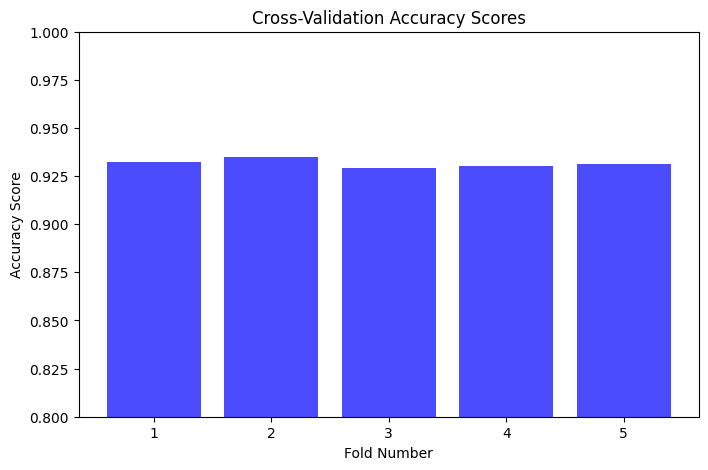

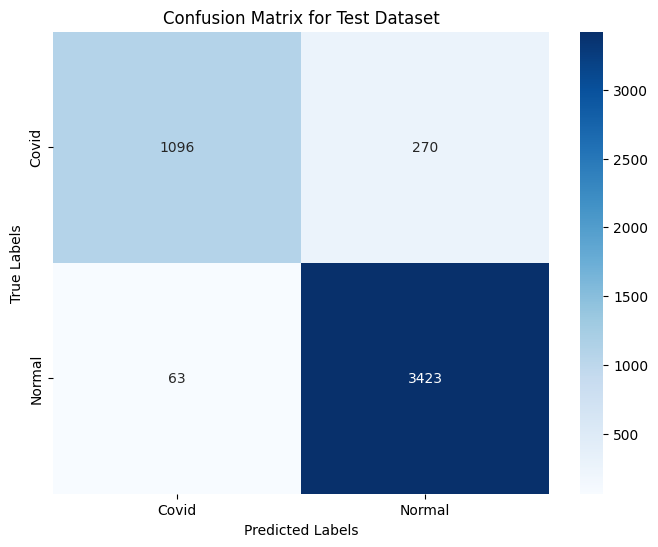

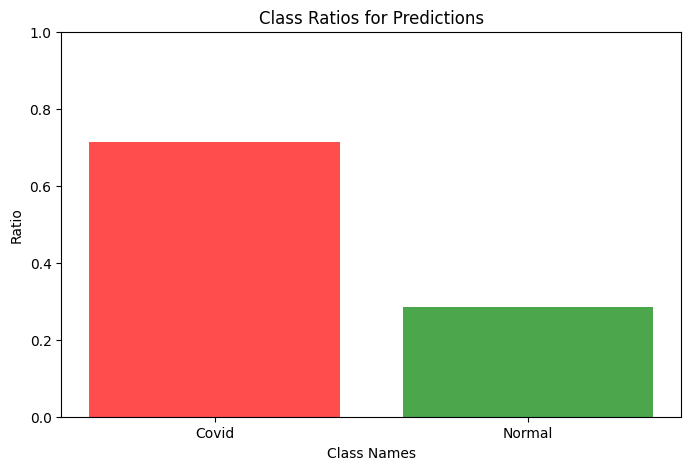

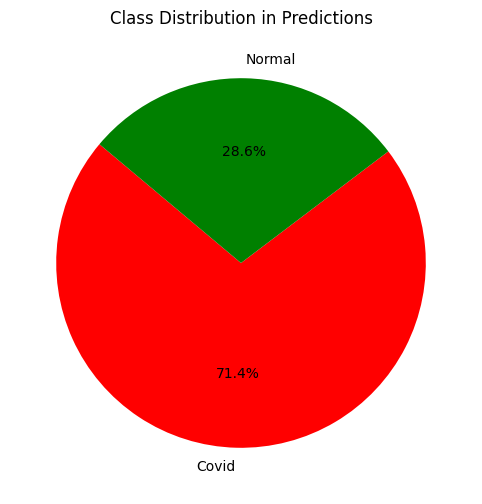

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Example: Cross-validation scores (dummy values for demonstration)
cross_val_scores = [0.93242049, 0.93507067, 0.92932862, 0.93021201, 0.93150685]  # Replace with your actual values

# Cross-Validation Scores Bar Plot
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(cross_val_scores) + 1), cross_val_scores, color='blue', alpha=0.7)
plt.xlabel('Fold Number')
plt.ylabel('Accuracy Score')
plt.title('Cross-Validation Accuracy Scores')
plt.ylim(0.8, 1.0)
plt.xticks(range(1, len(cross_val_scores) + 1))
plt.show()

# Example: Confusion Matrix (dummy values for demonstration)
confusion_matrix_data = np.array([[1096, 270],
                                  [63, 3423]
                                  ])  # Replace with your actual confusion matrix

# Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_data, annot=True, fmt="d", cmap="Blues", xticklabels=["Covid", "Normal"],
            yticklabels=["Covid", "Normal"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Test Dataset')
plt.show()

# Example: Predicted Class Ratios (dummy values for demonstration)
class_counts = {'Covid': 50, 'Normal': 20}  # Replace with your actual counts
total_predictions = sum(class_counts.values())

# Bar Chart for Class Ratios
plt.figure(figsize=(8, 5))
plt.bar(class_counts.keys(), [v / total_predictions for v in class_counts.values()], color=['red', 'green', 'blue'], alpha=0.7)
plt.xlabel('Class Names')
plt.ylabel('Ratio')
plt.title('Class Ratios for Predictions')
plt.ylim(0, 1)
plt.show()

# Pie Chart for Class Ratios
plt.figure(figsize=(8, 6))
plt.pie(class_counts.values(), labels=class_counts.keys(), autopct='%1.1f%%', colors=['red', 'green', 'blue'], startangle=140)
plt.title('Class Distribution in Predictions')
plt.show()


In [19]:
print("Classification Report (Test):")
print(classification_report(y_test, y_pred_test, target_names=["Covid", "Normal"], labels=[0, 2]))


Classification Report (Test):


NameError: name 'y_test' is not defined